<a href="https://colab.research.google.com/github/iyqht/simple-neural-network/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.56MB/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [5]:
test_data = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [96]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 9, 3, 1)
    self.conv2 = nn.Conv2d(9, 20, 3, 1)
    self.fc1 = nn.Linear(5 * 5 * 20, 84)
    self.fc2 = nn.Linear(84, 120)
    self.fc3 = nn.Linear(120, 84)
    self.fc4 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 20 * 5 * 5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = self.fc4(X)
    return F.log_softmax(X, dim = 1)

In [98]:
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [100]:
epochs = 5
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b,(X_train, y_train) in enumerate(train_loader):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses.append(loss.item())
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr = (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss.item())
  test_correct.append(tst_corr)

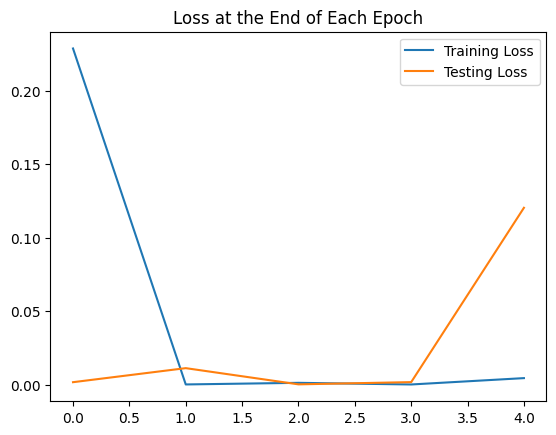

In [101]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the End of Each Epoch')
plt.legend()

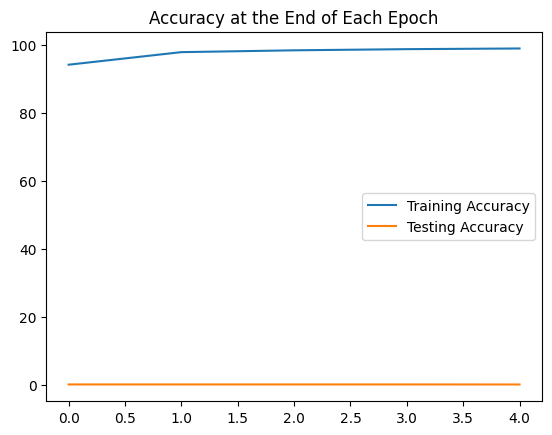

In [102]:
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the End of Each Epoch')
plt.legend()

In [103]:
all_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

In [104]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in all_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

print(f'Test Accuracy: {correct.item()/len(test_data)*100}%')

Test Accuracy: 98.68%


In [105]:
torch.save(model.state_dict(), "my_model.pth")

In [106]:
my_model = ConvolutionalNetwork()
my_model.load_state_dict(torch.load("my_model.pth"))

<ipython-input-106-8a282845c66b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load("my_model.pth"))


<All keys matched successfully>

In [107]:
my_model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(9, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

Predicted: "3", Actual: "3"


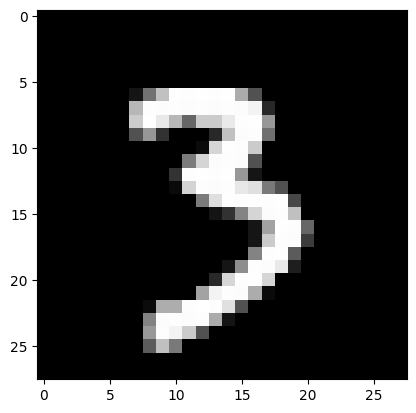

In [163]:
classes = [str(i) for i in range(10)]

sample = 30
x,y = test_data[sample][0], test_data[sample][1]

with torch.no_grad():
  pred = my_model(x)

  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')
  plt.imshow(x.squeeze(), cmap='gray')

tensor(8)


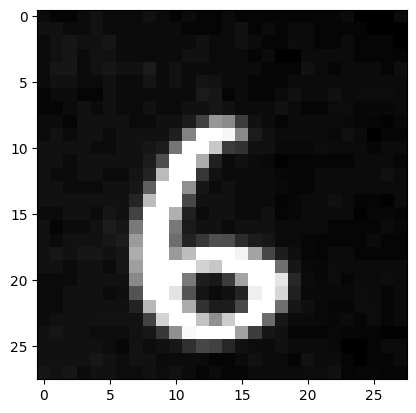

In [162]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/Upload/digit/6.jpg')

transform = transforms.Compose([
    transforms.CenterCrop(38*38),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])

img_tensor = transform(image)
img_tensor = transforms.functional.invert(img_tensor)
img_tensor = transforms.functional.adjust_contrast(img_tensor, 1.5)
img_tensor = transforms.functional.adjust_brightness(img_tensor, 1.5)

with torch.no_grad():
  pred = my_model(img_tensor)

  print(pred.argmax())
  plt.imshow(img_tensor.squeeze(), cmap='gray')